In [37]:
import pandas as pd
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import numpy as np 
import re
import nltk # <--- Package used for NLP
import matplotlib.pyplot as plt
%matplotlib inline
from wordcloud import WordCloud
import seaborn as sns
from nltk.corpus import stopwords
import langid
import re
from nltk import pos_tag
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from collections import Counter
import seaborn as sns

In [7]:
pip install langid

  Using cached langid-1.1.6.tar.gz (1.9 MB)
  Preparing metadata (setup.py) ... done
  Created wheel for langid: filename=langid-1.1.6-py3-none-any.whl size=1941173 sha256=7532535d3e647c3a68cc5198a66d253beac05d05ab2576cdee8159b7890e8b3b
  Stored in directory: /Users/BrianPark/Library/Caches/pip/wheels/32/6a/b6/b7eb43a6ad55b139c15c5daa29f3707659cfa6944d3c696f5b
Successfully built langid
Note: you may need to restart the kernel to use updated packages.


In [11]:
# ASSIGN SENTIMENT TO A SPECIFIED COLUMN OF OUR DATAFRAME
def assign_sentiment(df, text_column):
    analyzer = SentimentIntensityAnalyzer()

    # store sentiment labels
    sentiment_labels = []
    sentiment_levels = []

    # assign sentiment labels
    for text in df[text_column]:
        sentiment = analyzer.polarity_scores(text)
        sentiment_levels.append(sentiment['compound'])         
        if sentiment['compound'] >= 0.05:
            sentiment_labels.append('positive')
        elif sentiment['compound'] <= -0.05:
            sentiment_labels.append('negative')
        else:
            sentiment_labels.append('neutral')

    # create a new column of the df with the sentiment labels
    df['Sentiment'] = sentiment_labels
    df['Sentiment_Level'] = sentiment_levels
    return df


In [12]:
merged_tweets = pd.read_csv("merged_df.csv", low_memory=False)
df = assign_sentiment(merged_tweets, 'complex_lemmatized_column')

In [13]:
# Add column NegativeRatio which is ratio of negative tweets to all other tweets sent by the same User
df['NegativeRatio'] = df.groupby('User')['Sentiment'].transform(lambda x: (x == 'negative').mean())

#Number of Tweets Per User
df['TweetsCount'] = df.groupby('User')['User'].transform('count')

#Average Sentiment Level Per User
df['AvgSentimentLevel'] = df.groupby('User')['Sentiment_Level'].transform('mean')

In [14]:
#Average Tweets Per User 12.38

mean_tweet_count = df['TweetsCount'].mean()
mean_tweet_count

12.38132384570719

In [15]:
## Add threat Level Based on NegativeTweet Ratio and AvgSentiment Level of tweets per User
threat = []
for i in range(len(df['NegativeRatio'])):
    if df['NegativeRatio'][i] >= .45 and df['AvgSentimentLevel'][i] <= -0.2:
        threat.append("Red")
    elif df['NegativeRatio'][i] < .35 and df['AvgSentimentLevel'][i] >= 0.2:
        threat.append("Green")
    else:
        threat.append("Yellow")
        
df['Threat'] = threat

In [16]:
df

,User,Username,UTC Date,Tweet,Permalink,Is_English,complex_lemmatized_column,Unnamed: 0,Translated,Sentiment,Sentiment_Level,NegativeRatio,TweetsCount,AvgSentimentLevel,Threat
0,Gary Hill,@hillg367,2023-01-30 19:39:18,RT @davenewworld_2: 4 white supremacists in Wa...,https://www.twitter.com/user/status/1620144641...,1,RT @ davenewworld_2 : 4 white supremacist in W...,NaN,NaN,negative,-0.8860,0.750000,4.0,-0.564225,Red
1,خالد الشعيبي,@qwe716128968,2023-01-30 19:39:16,The US directly targeted all economic sectors ...,https://www.twitter.com/user/status/1620144636...,1,The US directly target all economic sector in ...,NaN,NaN,negative,-0.0516,0.666667,3.0,-0.289633,Red
2,ampk.95,@ampk_95,2023-01-30 19:39:16,@mccnshyne @akitoshinonome Not really an otome...,https://www.twitter.com/user/status/1620144635...,1,@ mccnshyne @ akitoshinonome Not really an oto...,NaN,NaN,positive,0.1875,0.000000,1.0,0.187500,Yellow
3,عبدالله,@bdllh16716948,2023-01-30 19:39:15,Every aspect of life in #Yemen was targeted by...,https://www.twitter.com/user/status/1620144629...,1,Every aspect of life in # Yemen be target by t...,NaN,NaN,neutral,0.0382,0.000000,2.0,0.155700,Yellow
4,llwry,@LLLwry,2023-01-30 19:39:14,RT @davenewworld_2: 4 white supremacists in Wa...,https://www.twitter.com/user/status/1620144627...,1,RT @ davenewworld_2 : 4 white supremacist in W...,NaN,NaN,negative,-0.8860,0.461538,13.0,0.000477,Yellow
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
459854,B V Prasad Reddy,@bvprasadreddy,2023-01-20 01:31:51,"నీచులు\nసమాజంలో\nచెడు నీచం పెంచడం కోసం,\nమంచిన...",https://www.twitter.com/user/status/1616247098...,0,The misery In society For raise the bad misera...,458789.0,The miseries\nIn society\nFor raising the bad ...,negative,-0.9035,0.666667,6.0,-0.339017,Red
459855,🐨❤🍯🧸🌸🍡🌈🌟,@eiLoJDaPKooL,2023-01-20 01:23:00,RT @inspoPageant: HIT THE POINT/ \n\nในรอบ clo...,https://www.twitter.com/user/status/1616244869...,0,RT @ inspopageant : Hit the Point/ In the Clos...,458852.0,RT @inspopageant: Hit the Point/\n\nIn the Clo...,positive,0.5859,0.000000,1.0,0.585900,Green
459856,prw83,@prw83,2023-01-20 01:13:14,RT @inspoPageant: HIT THE POINT/ \n\nในรอบ clo...,https://www.twitter.com/user/status/1616242414...,0,RT @ inspopageant : Hit the Point/ In the Clos...,458938.0,RT @inspopageant: Hit the Point/\n\nIn the Clo...,positive,0.5859,0.000000,1.0,0.585900,Green
459857,อิmnetอิชิบหาย,@ooyopiu,2023-01-20 00:58:27,RT @inspoPageant: HIT THE POINT/ \n\nในรอบ clo...,https://www.twitter.com/user/status/1616238693...,0,RT @ inspopageant : Hit the Point/ In the Clos...,459036.0,RT @inspopageant: Hit the Point/\n\nIn the Clo...,positive,0.5859,0.000000,1.0,0.585900,Green


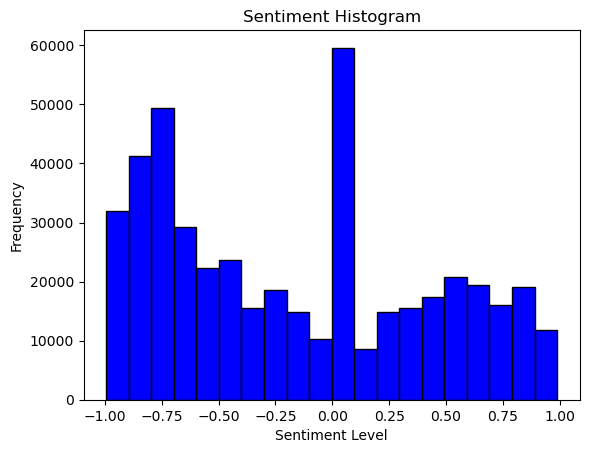

In [17]:
# Create a histogram
plt.hist(df['Sentiment_Level'], bins=20, color='blue', edgecolor='black')

# Customize the plot
plt.title('Sentiment Histogram')
plt.xlabel('Sentiment Level')
plt.ylabel('Frequency')

# Show the plot
plt.show()

(-1.1, 1.1)

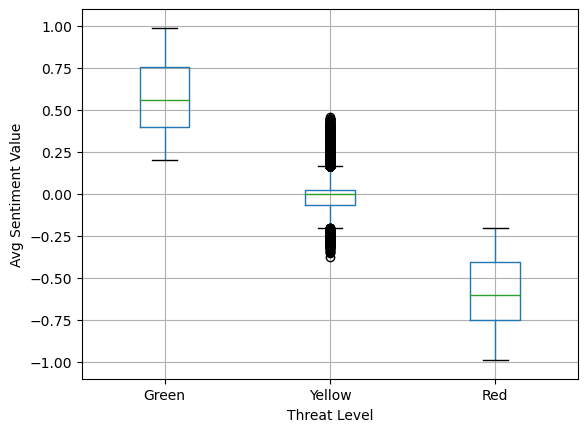

In [18]:
##Data Frame where duplicate tweets of Users are dropped
no_dupes_df = df.drop_duplicates(subset='User')

# BoxPlot of distribution of Avg sentiment values based on Threat Level
green = []
yellow = []
red = []

for index, row in no_dupes_df.iterrows():
    if row['Threat'] == "Red":
        red.append(row['AvgSentimentLevel'])
    elif row['Threat'] == "Yellow":
        yellow.append(row['AvgSentimentLevel'])
    elif row['Threat'] == "Green":
        green.append(row['AvgSentimentLevel'])

df1 = pd.DataFrame(list(zip(green, yellow, red)), columns=["Green", "Yellow", "Red"])
boxplot = df1.boxplot(column=["Green", "Yellow", "Red"])
boxplot.set_ylabel('Avg Sentiment Value')
boxplot.set_xlabel('Threat Level')
boxplot.set_ylim(-1.1, 1.1)

In [19]:
##Descriptive Statistics for Threats

df1["Red"].describe(), df1["Green"].describe(), df1["Yellow"].describe()

(count    60897.000000
 mean        -0.590065
 std          0.211962
 min         -0.991250
 25%         -0.750600
 50%         -0.599400
 75%         -0.405043
 max         -0.200025
 Name: Red, dtype: float64,
 count    60897.000000
 mean         0.568211
 std          0.210585
 min          0.200000
 25%          0.400300
 50%          0.557400
 75%          0.753600
 max          0.988000
 Name: Green, dtype: float64,
 count    60896.000000
 mean        -0.007245
 std          0.100135
 min         -0.373757
 25%         -0.066500
 50%          0.000000
 75%          0.025800
 max          0.456650
 Name: Yellow, dtype: float64)

<Axes: xlabel='Sentiment', ylabel='Sentiment Value'>

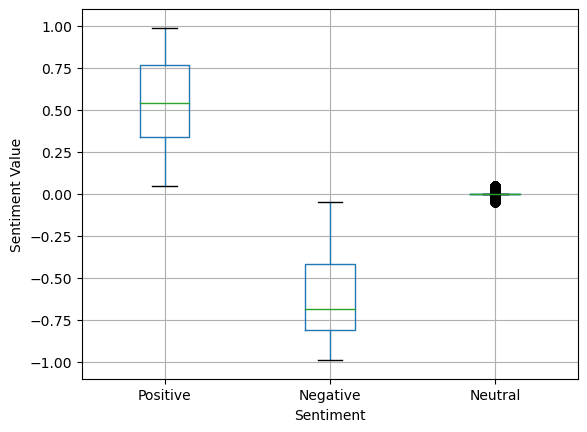

In [20]:
##BoxPlot of distribution of sentiment values
positive = []
negative = []
neutral = []


for i in range(len(df.Sentiment_Level)):
    if df.Sentiment[i] == "positive":
        positive.append(df.Sentiment_Level[i])
    if df.Sentiment[i] == "negative":
        negative.append(df.Sentiment_Level[i])
    if df.Sentiment[i] == "neutral":
        neutral.append(df.Sentiment_Level[i])


df1 = pd.DataFrame(list(zip(positive, negative, neutral)), columns= ["Positive", "Negative", "Neutral"])
boxplot = df1.boxplot(column=["Positive", "Negative", "Neutral"])
boxplot.set_ylabel('Sentiment Value')
boxplot.set_xlabel('Sentiment')
boxplot.set_ylim(-1.1, 1.1)
boxplot



In [21]:
##Descriptive Statistics for Sentiments

df1["Positive"].describe(), df1["Negative"].describe(), df1["Neutral"].describe()

(count    57388.000000
 mean         0.538291
 std          0.249312
 min          0.050000
 25%          0.340000
 50%          0.540250
 75%          0.764575
 max          0.986300
 Name: Positive, dtype: float64,
 count    57388.000000
 mean        -0.604124
 std          0.254536
 min         -0.989500
 25%         -0.807400
 50%         -0.685800
 75%         -0.416800
 max         -0.050100
 Name: Negative, dtype: float64,
 count    57388.000000
 mean        -0.000142
 std          0.009754
 min         -0.049800
 25%          0.000000
 50%          0.000000
 75%          0.000000
 max          0.049800
 Name: Neutral, dtype: float64)

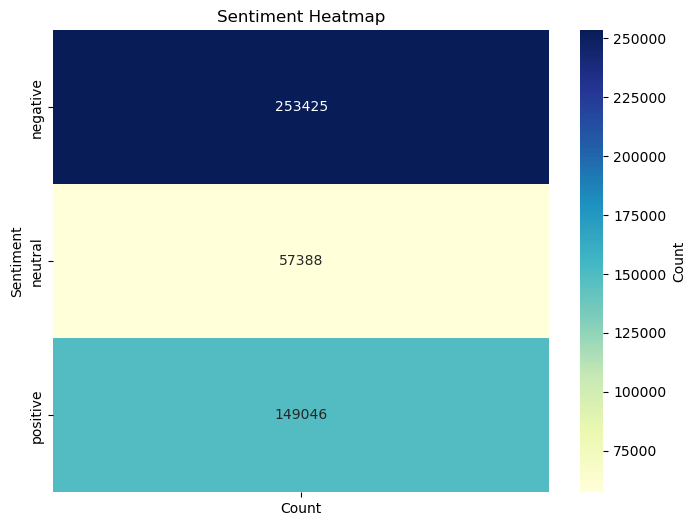

In [22]:
#################
df_sorted = df.sort_values(by='Sentiment_Level', ascending=False)

# Count the occurrences of each sentiment level
sentiment_counts = df['Sentiment'].value_counts().reset_index()

# Rename the columns for clarity
sentiment_counts.columns = ['Sentiment', 'Count']

# Create a pivot table for the heatmap
heatmap_data = sentiment_counts.pivot_table(index='Sentiment', values='Count', aggfunc='sum').fillna(0)

# Create a heatmap using seaborn number of occurances of each sentiment level
plt.figure(figsize=(8, 6))
sns.heatmap(heatmap_data, annot=True, cmap='YlGnBu', fmt='g', cbar_kws={'label': 'Count'})
plt.title('Sentiment Heatmap')
plt.show()

In [23]:
######Explanation for identical tweets is users retweeting things.

In [24]:
df_lowest_sentiment = df.nsmallest(40, 'Sentiment_Level')

# Join the selected tweets into a single string
tweets = ' '.join(df_lowest_sentiment['complex_lemmatized_column'])

In [25]:
#Clean top 40 most negative tweets for heatmap

# Preprocess the text (remove stopwords, convert to lowercase)
stop_words = set(stopwords.words('english'))
processed_text = ' '.join([word.lower() for word in tweets.split() if word.lower() not in stop_words])

def is_english(text):
    # Detect language using langid
    lang, _ = langid.classify(text)
    return lang == 'en'

def preprocess_text(text):
    # Remove hyperlinks
    text = re.sub(r'https?://\S+', '', text)

    # Remove strings starting with "#"
    text = re.sub(r'#\w+', '', text)

    # Remove strings starting with "@"
    text = re.sub(r'@\w+', '', text)

    # Remove "rt" (retweets)
    text = re.sub(r'\bRT\b', '', text, flags=re.IGNORECASE)

    # Remove strings that start with "$"
    text = re.sub(r'$\w+', '', text)

    # Remove special characters
    text = re.sub(r'[^\w\s]', '', text)

    # Remove non-English text
    english_text = ' '.join([word for word in text.split() if is_english(word)])
    
    # Remove strings ending with ":"
    cleaned_text = re.sub(r'\b\w+:\b', '', english_text)
    
    # Remove non-words
    cleaned_text = re.sub(r'\W', ' ', cleaned_text)
    
    cleaned_text = re.sub(r'\W|\d|\b\w*\d\w*\b', ' ', cleaned_text)
    
    # Tokenize the text
    tokens = word_tokenize(cleaned_text)
    
    # Remove stopwords and proper nouns
    stop_words = set(stopwords.words('english'))
    tagged_tokens = pos_tag(tokens)
    
    filtered_tokens = [word for word, pos in tagged_tokens if word.lower() not in stop_words and pos != 'NNP']
    
    # Join the tokens back into a string
    cleaned_text = ' '.join(filtered_tokens)
    
    cleaned_text = re.sub(r'\d+', '', cleaned_text)
    
    # Remove words containing numbers
    cleaned_text = ' '.join(word for word in cleaned_text.split() if not any(char.isdigit() for char in word))
    cleaned_text = cleaned_text.replace("http", "")
    
    cleaned_text = re.sub(r'http\S+|\bamp\b', '', cleaned_text)
    
    cleaned_text = re.sub(r'\b\w*_\w*\b|\b\w\b', '', cleaned_text)
    
    return cleaned_text

cleaned_text = preprocess_text(processed_text)

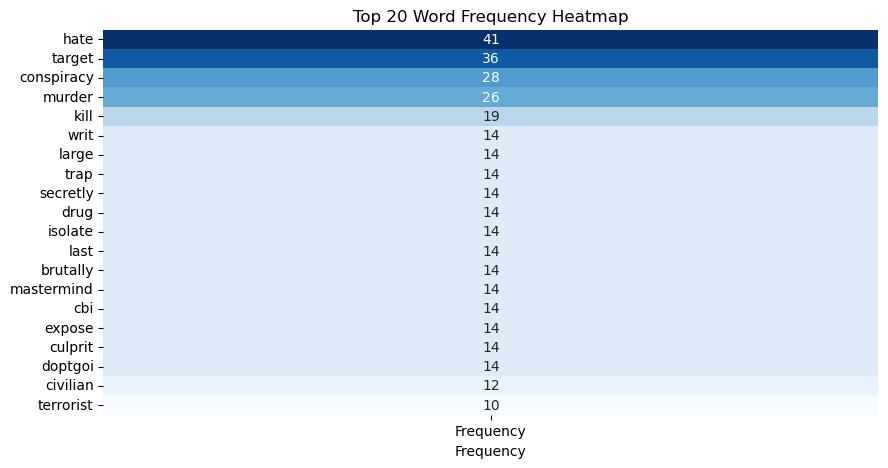

In [26]:
#HeatMap of 20 most frequenct words in the 40 most negative tweets.


# Tokenize the text and calculate word frequencies
words = cleaned_text.lower().split()
word_counts = Counter(words)

# Convert word frequencies to a DataFrame for seaborn
data = {'Word': list(word_counts.keys()), 'Frequency': list(word_counts.values())}
df2 = pd.DataFrame(data)

# Select the top 20 words
df_top20 = df2.nlargest(20, 'Frequency')

# Create a heatmap for the top 20 words
plt.figure(figsize=(10, 5))
sns.heatmap(df_top20[['Frequency']], annot=True, fmt='d', cmap='Blues', cbar=False, yticklabels=df_top20['Word'])
plt.xlabel('Frequency')
plt.title('Top 20 Word Frequency Heatmap')
plt.show()

#cbi - Central Bureau of Investigation (CBI) is the domestic crime investigating agency of India
#writ - is an order from a higher court to a lower court or to a governmental official,
#DOTGOI, Department of Tourism, Government of India

In [42]:
#Word Cloud of most common words for 20 most negative users(Potential Threats)
# Create a WordCloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(cleaned_text)

# Convert the WordCloud to DataFrame
wordcloud_df = pd.DataFrame(wordcloud.words_.items(), columns=['Word', 'Frequency'])

# Create a heatmap using seaborn
plt.figure(figsize=(10, 8))
heatmap_data = pd.crosstab(index=None, columns=wordcloud_df['Word'], values=wordcloud_df['Frequency'], aggfunc='sum').fillna(0)
sns.heatmap(heatmap_data, cmap='YlGnBu', annot=True, cbar_kws={'label': 'Frequency'})
plt.title('Top 20 Most Occurring Words in Tweet Column')
plt.show()

ValueError: zero-size array to reduction operation fmin which has no identity

<Figure size 1000x800 with 0 Axes>

In [30]:
# Separate our data into features and labels
features = df.iloc[:, 6].values
labels = df.iloc[:, 9].values

In [31]:
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer

# Set max_df to 0.95 to exclude "targeted" since its in every tweet 
vectorizer = TfidfVectorizer(max_features=5000, min_df=7, max_df=0.95, stop_words=stopwords.words('english'))
processed_features = vectorizer.fit_transform(features).toarray()

In [32]:
from sklearn.model_selection import train_test_split
from scipy.sparse import csr_matrix

sparse_features = csr_matrix(processed_features)
# Split our data into testing and training data, with our X data being the
# processed_features (translated/lemmatized tweets), and Y being our labels (sentiment)
X_train, X_test, y_train, y_test = train_test_split(sparse_features, labels, test_size=0.2, random_state=0)

In [33]:
from sklearn.ensemble import RandomForestClassifier

# Roughly 13 minutes to run
# Use the random forest classifier, train our model using the X and Y training sets
text_classifier = RandomForestClassifier(n_estimators=100, random_state=0, n_jobs=-1)
text_classifier.fit(X_train, y_train)

RandomForestClassifier(n_jobs=-1, random_state=0)

In [34]:
# Use the predict function on the X testing data
predictions = text_classifier.predict(X_test)

In [35]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
# Print our classification report which includes precision, recall, f1-score, and support
print(classification_report(y_test,predictions))
# print the accuracy score of the model
print(f"Accuracy: {accuracy_score(y_test, predictions):.4f}")
# print the confusion matrix
print(confusion_matrix(y_test, predictions))

              precision    recall  f1-score   support

    negative       0.93      0.95      0.94     50648
     neutral       0.89      0.85      0.87     11590
    positive       0.93      0.90      0.91     29734

    accuracy                           0.92     91972
   macro avg       0.92      0.90      0.91     91972
weighted avg       0.92      0.92      0.92     91972

Accuracy: 0.9240
[[48315   656  1677]
 [ 1335  9831   424]
 [ 2390   511 26833]]
